**Environment Setup**

First, install all necessary libraries. Also use spacy for tokenization and other libraries for data handling and visualization.

In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install spacy
!pip install tqdm seaborn
!python -m spacy download en_core_web_sm


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Import Libraries**

Import all the required libraries for data processing, model building, training, and visualization.

In [2]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm  # Progress bar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import spacy
from collections import Counter


**Set Seeds and Device**

Setting seeds ensures reproducibility of results. Check if a GPU is available for faster computation.

In [3]:
# Print PyTorch and CUDA information
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

# Set seeds for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch Version: 2.5.1+cu121
CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA A100-SXM4-40GB
Using device: cuda


**Prepare Dataset**

Use the pre-extracted dataset. They data is organized into CSV files with one sentence per line.

In [4]:
# Helper function to read a CSV file with one sentence per line
def read_csv_file(filepath, label, max_samples=None):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_samples and i >= max_samples:
                break
            text = line.strip()
            if text:
                data.append((label, text))
    return data


DATA_DIR = "/content"


# Specify the maximum number of samples per file (e.g., 5000)
MAX_SAMPLES = 5000

# Read the CSV files
train_pos = read_csv_file(os.path.join(DATA_DIR, 'train_pos.csv'), label=1, max_samples=MAX_SAMPLES)
train_neg = read_csv_file(os.path.join(DATA_DIR, 'train_neg.csv'), label=0, max_samples=MAX_SAMPLES)
test_pos = read_csv_file(os.path.join(DATA_DIR, 'test_pos.csv'), label=1, max_samples=MAX_SAMPLES)
test_neg = read_csv_file(os.path.join(DATA_DIR, 'test_neg.csv'), label=0, max_samples=MAX_SAMPLES)

# Optionally read unsupervised training data if available
# train_unsup = read_csv_file(os.path.join(DATA_DIR, 'train_unsup.csv'), label=None, max_samples=MAX_SAMPLES)
# train_data = train_pos + train_neg + train_unsup
# Otherwise, proceed without unsupervised data
train_data = train_pos + train_neg
test_data = test_pos + test_neg

print(f"Total training samples: {len(train_data)}")
print(f"Total test samples: {len(test_data)}")

Total training samples: 10000
Total test samples: 10000


**Tokenization and Vocabulary Building**

Tokenization splits sentences into words (tokens). Use spacy for efficient tokenization. After tokenizing, willbuild a vocabulary mapping each unique token to an integer index.

In [5]:
# Load spaCy English model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully.")
except OSError:
    print("spaCy model not found. Downloading 'en_core_web_sm'...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully after downloading.")

# Tokenization function
def tokenize(text, nlp):
    return [tok.text.lower() for tok in nlp(text)]

# Example tokenization
sample_text = "This is a fantastic movie! I loved every moment of it."
tokens = tokenize(sample_text, nlp)
print(f"Tokens: {tokens}")

# Build Vocabulary
texts = [text for label, text in train_data]

# Initialize Counter
counter = Counter()

# Tokenize all texts and update the counter
print("Building vocabulary...")
for doc in tqdm(nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]), total=len(texts), desc="Tokenizing"):
    tokens = [tok.text.lower() for tok in doc]
    counter.update(tokens)

# Keep top 25,000 words
most_common = counter.most_common(25000)
vocab_words = [word for word, freq in most_common]

# Add special tokens
special_tokens = ['<pad>', '<unk>']
stoi = {w: i + len(special_tokens) for i, w in enumerate(vocab_words)}
stoi['<pad>'] = 0
stoi['<unk>'] = 1
itos = {i: w for w, i in stoi.items()}

print(f"Vocabulary size: {len(stoi)}")


spaCy model loaded successfully.
Tokens: ['this', 'is', 'a', 'fantastic', 'movie', '!', 'i', 'loved', 'every', 'moment', 'of', 'it', '.']
Building vocabulary...


Tokenizing: 100%|██████████| 10000/10000 [00:18<00:00, 526.91it/s]

Vocabulary size: 18111


**Create PyTorch Dataset and DataLoader**

Create a custom Dataset class to handle our data and a DataLoader for batching. Padding ensures that all sequences in a batch have the same length.

In [6]:
# Define a custom Dataset
class IMDBDataset(Dataset):
    def __init__(self, data, stoi, nlp, max_length=None):
        self.data = data
        self.stoi = stoi
        self.nlp = nlp
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        tokens = tokenize(text, self.nlp)
        numericalized = [self.stoi.get(t, self.stoi['<unk>']) for t in tokens]
        if self.max_length:
            numericalized = numericalized[:self.max_length]
        return torch.tensor(numericalized, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Define a Collate Function for DataLoader
class CollateFn:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        texts, labels = zip(*batch)
        lengths = torch.tensor([len(x) for x in texts], dtype=torch.long)
        padded_texts = pad_sequence(texts, batch_first=True, padding_value=self.pad_idx)
        return padded_texts, lengths, torch.tensor(labels, dtype=torch.float)

# Split training data into train and validation sets
random.shuffle(train_data)
split_ratio = 0.8
split_index = int(len(train_data) * split_ratio)
valid_data = train_data[split_index:]
train_data = train_data[:split_index]

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

# Create datasets
MAX_LENGTH = 256
train_dataset = IMDBDataset(train_data, stoi, nlp, max_length=MAX_LENGTH)
valid_dataset = IMDBDataset(valid_data, stoi, nlp, max_length=MAX_LENGTH)
test_dataset = IMDBDataset(test_data, stoi, nlp, max_length=MAX_LENGTH)

# Create DataLoaders
PAD_IDX = stoi['<pad>']
collate_fn_instance = CollateFn(pad_idx=PAD_IDX)

BATCH_SIZE = 128
NUM_WORKERS = 4
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created.")


Train samples: 8000
Validation samples: 2000
Test samples: 10000
DataLoaders created.


**Define the RNN Model**

Define an RNN model with LSTM layers. The model includes an embedding layer, LSTM, dropout, and a fully connected layer for binary classification.

In [7]:
# Define the Sentiment RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack the sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        if self.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        output = self.fc(hidden)
        return output.squeeze(1)


**Training and Evaluation**

Define the training and evaluation functions. Use Binary Cross-Entropy loss with logits and the Adam optimizer. Also track accuracy during training.

In [8]:
# Initialize Model, Optimizer, Loss
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3

model = SentimentRNN(
    vocab_size=len(stoi),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Initialize embeddings for special tokens
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[stoi['<unk>']] = torch.zeros(EMBEDDING_DIM)

model = model.to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

# Define accuracy metric
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch.
    """
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(preds)
    # Round to get binary predictions
    rounded = torch.round(probs)
    correct = (rounded == y).float()
    return correct.sum() / len(correct)

# Training function
def train_fn(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for texts, lengths, labels in tqdm(loader, desc="Training"):
        # Move data to device
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Evaluation function
def eval_fn(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for texts, lengths, labels in tqdm(loader, desc='Evaluating'):
            texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
            predictions = model(texts, lengths)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)


**Train the Model**

Train the model for a specified number of epochs, saving the best model based on validation loss.

In [9]:
# Train the Model
N_EPOCHS = 7
best_valid_loss = float('inf')

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch + 1}/{N_EPOCHS}")
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = eval_fn(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
        print(f"  Best model saved (Validation Loss: {valid_loss:.4f})")

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc * 100:.2f}%\n")


Epoch: 1/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


  Best model saved (Validation Loss: 0.6799)
  Train Loss: 0.6873 | Train Acc: 54.32%
  Valid Loss: 0.6799 | Valid Acc: 56.66%

Epoch: 2/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


  Best model saved (Validation Loss: 0.6364)
  Train Loss: 0.6444 | Train Acc: 63.64%
  Valid Loss: 0.6364 | Valid Acc: 64.52%

Epoch: 3/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


  Train Loss: 0.5718 | Train Acc: 70.47%
  Valid Loss: 0.6391 | Valid Acc: 66.56%

Epoch: 4/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


  Train Loss: 0.4741 | Train Acc: 77.98%
  Valid Loss: 0.6560 | Valid Acc: 67.35%

Epoch: 5/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


  Train Loss: 0.3538 | Train Acc: 84.85%
  Valid Loss: 0.7746 | Valid Acc: 65.71%

Epoch: 6/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


  Train Loss: 0.2453 | Train Acc: 89.53%
  Valid Loss: 0.7204 | Valid Acc: 68.95%

Epoch: 7/7


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

  Train Loss: 0.1505 | Train Acc: 94.30%
  Valid Loss: 0.9689 | Valid Acc: 67.65%



**Visualization**

Visualize the training and validation loss and accuracy over epochs using matplotlib and seaborn.

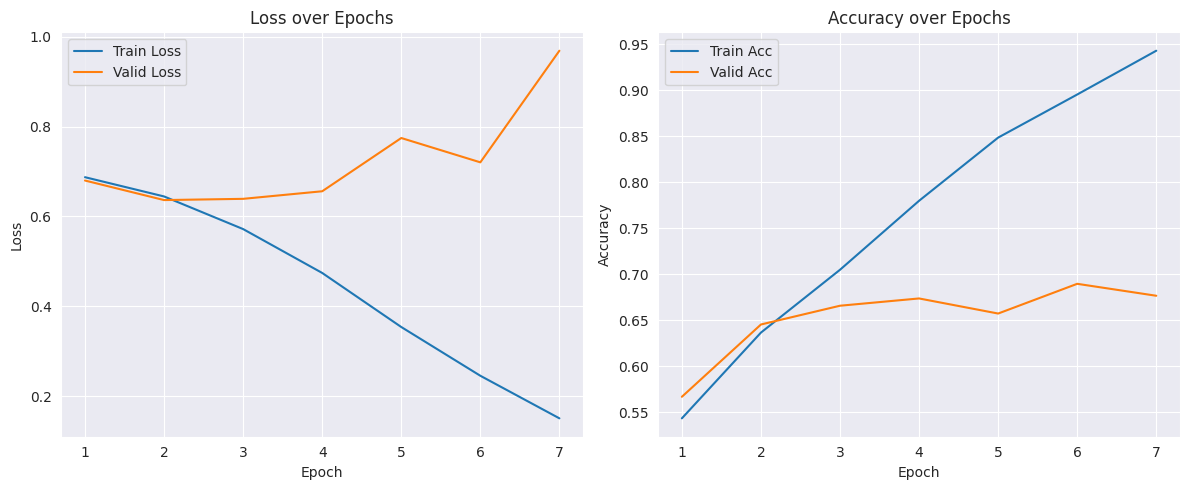

In [10]:
# Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), valid_losses, label='Valid Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, N_EPOCHS + 1), valid_accuracies, label='Valid Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Evaluate on Test Data
Load the best model and evaluate its performance on the test dataset.

In [11]:
# Load the best model
model.load_state_dict(torch.load('best-model.pt'))

# Evaluate on test data
test_loss, test_acc = eval_fn(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")


<ipython-input-11-66bdd5dec92d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.pt'))
Evaluating: 100%|██████████| 79/79 [00:22

Test Loss: 0.6782 | Test Accuracy: 60.14%


**Confusion Matrix**

Generate a confusion matrix to visualize the performance of the model on the test set.

Predicting: 100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


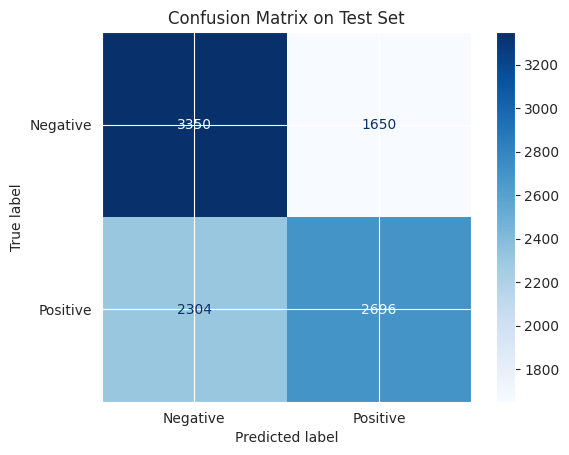

In [12]:
# Function to get predictions and labels
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, lengths, labels in tqdm(loader, desc='Predicting'):
            texts, lengths = texts.to(device), lengths.to(device)
            predictions = torch.sigmoid(model(texts, lengths))
            preds = torch.round(predictions)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Get predictions and labels
test_preds, test_labels = get_predictions(model, test_loader, device)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()


**Predict on Custom Sentences**

Use the trained model to predict the sentiment of custom movie reviews.

In [13]:
# Function to predict sentiment of a single sentence
def predict_sentiment(model, text, stoi, nlp, device, max_length=256):
    model.eval()
    tokens = tokenize(text, nlp)
    numericalized = [stoi.get(t, stoi['<unk>']) for t in tokens]
    if len(numericalized) > max_length:
        numericalized = numericalized[:max_length]
    lengths = torch.tensor([len(numericalized)], dtype=torch.long).to(device)
    tensor = torch.tensor(numericalized, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor, lengths))
    return prediction.item()

# Sample reviews
sample_reviews = [
    "This movie was absolutely fantastic, I loved it!",
    "I hated this movie, it was so bad and boring.",
    "It was okay, not great but not terrible either.",
]

# Predict and display results
for review in sample_reviews:
    score = predict_sentiment(model, review, stoi, nlp, device)
    sentiment = "Positive" if score >= 0.5 else "Negative"
    print(f"Review: {review}\nPredicted: {sentiment} (Score: {score:.4f})\n")


Review: This movie was absolutely fantastic, I loved it!
Predicted: Negative (Score: 0.4925)

Review: I hated this movie, it was so bad and boring.
Predicted: Negative (Score: 0.2289)

Review: It was okay, not great but not terrible either.
Predicted: Negative (Score: 0.3821)

